# Limitation of unimodal conditional distribution

The goal of supervised learning is to model a conditional distibution $p(\mathbf{t}|\mathbf{x})$, which for many simple regression problem is chosen to be Gaussian. However, pratical machine learning problems can often have significantly non-Gaussian distibutions.


<IPython.core.display.Javascript object>


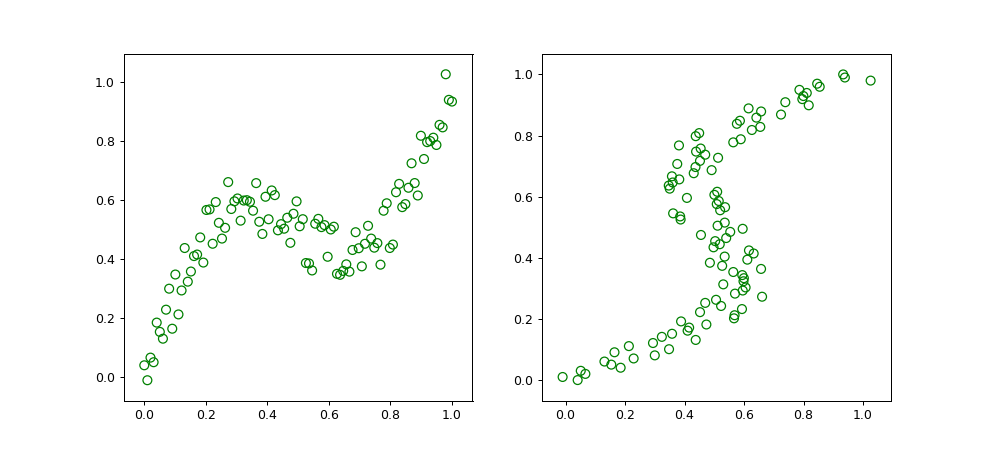

In [49]:
import matplotlib.pyplot as plt
import numpy as np

def main():
    fig = plt.figure(figsize=(11,5), dpi=60)
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    
    X = np.linspace(0,1,100)
    Noise = np.random.uniform(-0.1, 0.1, 100)
    T = X + 0.3*np.sin(2*np.pi*X) + Noise
    
    ax1.scatter(X, T, s=50,  facecolors='none', edgecolors='green')
    ax2.scatter(T, X, s=50,  facecolors='none', edgecolors='green')

    plt.show()

if __name__=="__main__":
    main()

------------

# Multimodal conditional distribution

We therefore seek a general framework for modeling conditional probability distributions. This can be achived by using a mixture model for $p(\mathbf{t}|\mathbf{w})$ in which both the mixing coefficients as well as the component densities are flexible functions of the input vector $\mathbf{x}$, giving rise to the *mixture density network*.

We can use various distributions for the components. Here we use Gaussian distibution and let the mean and variance depend on the input vector $\mathbf{x}$ in order to let these parameters adjust adaptively during learning. Then the conditional distribution takes the form

$$p(\mathbf{t}|\mathbf{x}) = \sum_{k=1}^K \pi_k(\mathbf{x})\mathcal{N}\big(\mathbf{t}|\mathbf{\mu}_k(\mathbf{x}),\sigma_k^2(\mathbf{x})\big) \tag{5.148}$$

------------

# Design a neural network

We then introduce neural network to determine the conditional distribution.

In (5.148), $\pi_k(\mathbf{x}), \mathbf{\mu}_k(\mathbf{x}), \sigma_k(\mathbf{x})$ are the unknown parameters depending on input vector $\mathbf{x}$. For finding the proper values of these parameters, we can build a network whose inputs are $\mathbf{x}$ and set its outputs to be these parameters.

## Error function
The error function is the negative logarithm of the likelihood. Less error means better fit to the training data.

$$E(\mathbf{w}) = -\sum_{n=1}^N\ln\left\{ \sum_{k=1}^K\pi_k(\mathbf{x}_n,\mathbf{w})\mathcal{N}\big(\mathbf{t}_n|\mathbf{\mu}_k(\mathbf{x}_n,\mathbf{w}), \sigma_k^2(\mathbf{x}_n, \mathbf{w})\big) \right\} \tag{5.153}$$


## Output layer constrains
While designing the output layer, we should follow the constrains of the parameters.

The mixing coefficients must satisfy the constraints

$$\sum_{k=1}^K \pi_k(\mathbf{x}) = 1, \qquad 0\leqslant \pi_k(\mathbf{x})\leqslant 1 \tag{5.149}$$

which can be achived using a set of softmax outputs

$$\pi_{k}(\mathbf{x}) = \frac{exp(a_k^{\pi})}{\sum_{l=1}^K exp(a_l^{\pi})} \tag{5.150}$$

Similarly, the variances must satisfy $\sigma_k^2(\mathbf{x})\geqslant 0$ and so can be represented in terms of the exponentials of the corresponding network activations using

$$\sigma_k(\mathbf{x}) = exp(a_k^{\sigma}) \tag{5.151}$$

Finally, because the means $\mathbf{\mu}_k(\mathbf{x})$ have real components, they can be represented directly by the network output activations.

$$\mu_{kj}(\mathbf{x}) = a_{kj}^{\mu} \tag{5.152}$$


## Output layer errors
<font color='red'>Our goal is to adjust the weights in the network by backpropagation in order to minimize the error function. Backpropagation requires us to provide the errors of the output layer on which the parameters $\pi_k, \mathbf{\mu}_k, \sigma_k$ lie. Recall that the errors are also known as the derivatives with respect to the network output activations.</font>

### The coefficients errors

$$\begin{align*}
\delta_k^{\pi} = \frac{\partial E_n}{\partial a_k^{\pi}}
&= \frac{\partial}{\partial a_k^{\pi}}\left(-\ln\left\{\sum_j \pi_j \mathcal{N}_{nj}\right\}\right)\\
&= -\frac{\partial}{\partial a_k^{\pi}}\left(\ln\left\{\sum_j \frac{exp(a_j^{\pi})}{\sum_{l} exp(a_l^{\pi})}\mathcal{N}_{nj}\right\}\right)\\
&= -\frac{\partial \ln S}{\partial S}\frac{\partial S}{\partial exp(a_k^{\pi})}\frac{\partial exp(a_k^{\pi})}{\partial a_k^{\pi}}\qquad \text{let }S = \frac{\sum_j exp(a_j^{\pi})\mathcal{N}_{nj}}{\sum_{l} exp(a_l^{\pi})}\\
&= -\frac{\sum_{l} exp(a_l^{\pi})}{\sum_j exp(a_j^{\pi})\mathcal{N}_{nj}}\cdot\frac{\mathcal{N}_{nk}\sum_{l} exp(a_l^{\pi})-\sum_j exp(a_j^{\pi})\mathcal{N}_{nj}}{\left(\sum_{l} exp(a_l^{\pi})\right)^2}\cdot exp(a_k^{\pi}) \qquad \text{Quotient rule}\\
&=-\frac{\mathcal{N}_{nk}exp(a_k^{\pi})}{\sum_j exp(a_j^{\pi})\mathcal{N}_{nj}}+\frac{exp(a_k^{\pi})}{\sum_{l} exp(a_l^{\pi})}\\
&=\pi_k - \gamma_k \tag{5.155}
\end{align*}$$

Because we are dealing with mixture distributions, it is convinient to view the mixing coefficients $\pi_k(\mathbf{x})$ as $\mathbf{x}$-dependent prior probabilities and the corresponding posterior probabilities is $\gamma_k$.

$$\gamma_k(\mathbf{t}|\mathbf{x}) = \frac{\pi_k\mathcal{N}_{nk}}{\sum_l \pi_l\mathcal{N}_{nl}} \tag{5.154}$$

where 

$$\mathcal{N}_{nk} = \mathcal{N}\big(\mathbf{t}_n|\mathbf{\mu}_k(\mathbf{x}_n), \sigma_k^2(\mathbf{x}_n)\big)
 = \frac{1}{\sqrt{2\pi}\sigma_k(\mathbf{x}_n)}exp\left\{-\frac{\|\mathbf{t}_n-\mathbf{\mu}_k(\mathbf{x}_n)\|^2}{2\sigma_k^2(\mathbf{x}_n)}\right\}$$

### The means errors

$$\begin{align*}
\delta_k^{\mu} = \frac{\partial E_n}{\partial a_{kl}^{\mu}}
&= \frac{\partial}{\partial a_{kl}^{\mu}}\left(-\ln\left\{\sum_j \pi_j \mathcal{N}_{nj}\right\}\right)\\
&= -\frac{\partial\ln(\sum_j\pi_j\mathcal{N}_{nj})}{\partial \sum_j\pi_j\mathcal{N}_{nj}}\cdot\frac{\partial \sum_j\pi_j\mathcal{N}_{nj}}{\partial \mathcal{N}_{nk}}\cdot\frac{\partial \mathcal{N}_{nk}}{\partial (-\|\mathbf{t}_n-\mathbf{\mu}_k\|^2/2\sigma_k^2)}\cdot \frac{\partial (-\|\mathbf{t}_n-\mathbf{\mu}_k\|^2/2\sigma_k^2)}{\partial \mu_{kl}}\cdot\frac{\mu_{kl}}{\partial a_{kl}^{\mu}}\\
&= -\frac{1}{\sum_j\pi_j\mathcal{N}_{nj}}\cdot \pi_k \cdot \mathcal{N}_{nk} \cdot \frac{t_l-\mu_{kl}}{\sigma_k^2}\cdot 1\\
&= \gamma_k\left\{\frac{\mu_{kl}-t_l}{\sigma_k^2}\right\} \tag{5.156}
\end{align*}$$


### The variances errors

$$\begin{align*}
\delta_k^{\sigma} = \frac{\partial E_n}{\partial a_{k}^{\sigma}}
&= \frac{\partial}{\partial a_{k}^{\sigma}}\left(-\ln\left\{\sum_j \pi_j \mathcal{N}_{nj}\right\}\right)\\
&= -\frac{\partial\ln(\sum_j\pi_j\mathcal{N}_{nj})}{\partial \sum_j\pi_j\mathcal{N}_{nj}}\cdot\frac{\partial \sum_j\pi_j\mathcal{N}_{nj}}{\partial \mathcal{N}_{nk}}\cdot\frac{\partial \mathcal{N}_{nk}}{\partial \sigma_k}\cdot \frac{\partial\sigma_k}{\partial a_{k}^{\sigma}}\\
&= -\frac{1}{\sum_j\pi_j\mathcal{N}_{nj}}\cdot \pi_k \cdot \mathcal{N}_{nk}(-\frac{1}{\sigma_k}+\frac{\|\mathbf{t}-\mathbf{\mu}_k\|^2}{\sigma_k^3}) \cdot \sigma_k\\
&= -\gamma_k\left\{\frac{\|\mathbf{t}-\mathbf{\mu}_k\|^2}{\sigma_k^2}-1\right\} \tag{5.157}
\end{align*}$$

<IPython.core.display.Javascript object>


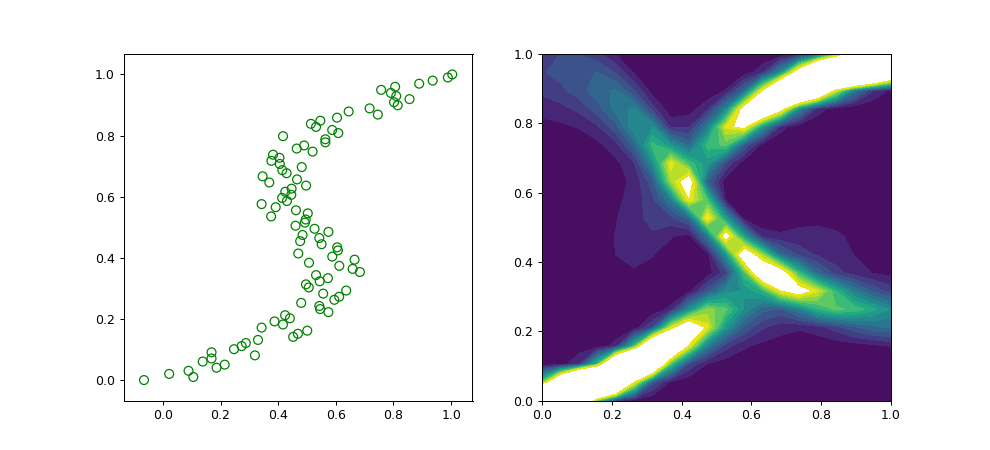

In [46]:
# for showing iteratively
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
import warnings

# convert warnings to error
warnings.filterwarnings("error")

LT = 10000
LR = 0.01
X = None
Y = None
x = None
y = None
cont = None
levels = None

Gaussian = lambda t, mu, sigma: 1.0/(sigma*np.sqrt(2*np.pi))*np.exp(-(t-mu)**2/(2*sigma**2))

def tanh(a):
    y = np.tanh(a)
    return y

def dtanh(o):
    y = 1-o**2
    return y

def compute_weights_error(derivatives, variance):
    ret = LR * variance * derivatives
    return ret

class Layer:
    network = None
    unit_number = 0
    outputs = None
    errors = None
    weights = None
    derivatives = None
    prev_layer = None
    next_layer = None
    variance = 0.0
    
    act_func = tanh
    link_func = dtanh
    
    def __init__(self, K, afunc=tanh, lfunc=dtanh):
        self.unit_number = K
        self.outputs = np.zeros(K)
        self.errors = np.zeros(K)
        self.act_func = afunc
        self.link_func = lfunc
        
    def build_connection(self, network):
        self.network = network
        j = self.prev_layer.unit_number
        self.variance = 1.0/(j * self.unit_number)
        self.weights = np.random.normal(0,\
                                        np.sqrt(self.variance),\
                                        (self.unit_number, j))
        self.derivatives = np.zeros((self.unit_number, j))
    
    def forward_propagation(self):
        for k in range(self.unit_number):
            self.outputs[k] = self.act_func(np.sum(self.prev_layer.outputs * self.weights[k]))
            
    def backward_propagation(self, update_weight):
        for k in range(self.unit_number):
            self.errors[k] = self.link_func(self.outputs[k]) * np.sum(self.next_layer.weights[:,k] * self.next_layer.errors)
            self.derivatives[k] += self.errors[k] * self.prev_layer.outputs
        if update_weight == 1:
            self.weights -= compute_weights_error(self.derivatives, self.variance)
            self.derivatives *= 0.0
            
    def dump(self):
        print("outputs {}".format(self.outputs))
        print("errors {}".format(self.errors))
        print("weights {}".format(self.weights))
        print("derivatives {}".format(self.derivatives))

# Mixture Gaussian Parameters Layer
class OutputLayer(Layer):
    K = 0
    def __init__(self, K):
        self.K = K
        self.unit_number = K * 3
        self.outputs = np.zeros(self.unit_number)
        self.errors = np.zeros(self.unit_number)
    
    def forward_propagation(self):
        a = np.zeros(self.unit_number)
        for k in range(self.unit_number):
            a[k] = np.sum(self.prev_layer.outputs * self.weights[k])
        ea = np.exp(a)
        for k in range(self.unit_number):
            if k < self.K:    # coefficients
                self.outputs[k] = ea[k]/np.sum(ea[:self.K])
            elif k < 2*self.K:    # standard deviations
                self.outputs[k] = ea[k]
            else:     # means
                self.outputs[k] = a[k]
    
    def backward_propagation(self, update_weight):
        G = self.K
        prob = np.zeros(G)
        coeffs, deviations, means = np.reshape(self.outputs, (-1, 3))[:]
        #coeffs = self.outputs[:G]
        #deviations = self.outputs[G:2*G]
        #means = self.outputs[2*G:]
        
        #print(self.outputs)
        if np.max(deviations) > 100:
            self.network.dump()
        for k in range(G):
            prob[k] = coeffs[k] * Gaussian(self.target, means[k], deviations[k])
        try:
            p = prob/np.sum(prob)
        except:
            self.network.dump()
            print("posterior probabilities are ", prob)
            print("coeffs are ", coeffs)
            print("means are ", means)
            print("deviations are ", deviations)
            print("target is ", self.target)
            raise Exception('error')
        
        for k in range(self.unit_number):
            if k < G: # coefficients
                self.errors[k] = coeffs[k] - p[k]
            elif k < 2*G:     # standard deviations
                self.errors[k] = -p[k-G] * ((self.target-means[k-G])**2/deviations[k-G]**2 - 1)
            else:   # means
                self.errors[k] = p[k-2*G] * (means[k-2*G]-self.target)/deviations[k-2*G]**2
                
            self.derivatives[k] += self.errors[k] * self.prev_layer.outputs
        
        if update_weight == 1:
            self.weights -= compute_weights_error(self.derivatives, self.variance)
            self.derivatives *= 0.0
            
    def update_target(self, t):
        self.target = t

class InputLayer(Layer):
    outputs = None
    unit_number = 0
    prev_layer = None
    next_layer = None
    
    def __init__(self, K):
        self.unit_number = K
        
    def build_connection(self, network):
        self.network = network
        return
        
    def update_input(self, inputs):
        self.outputs = inputs

class Network:
    input_layer = None
    output_layer = None
    inputs = None
    targets = None
    
    def __init__(self):
        return
    
    def add_layer(self, layer):
        if self.input_layer == None:
            self.input_layer = layer
        else:
            layer.prev_layer = self.output_layer
            self.output_layer.next_layer = layer
            
        self.output_layer = layer
        layer.build_connection(self)
        
    def train(self, observations, targets):
        N = len(observations)
        for n in range(N):
            self.input_layer.update_input(observations[n])
            self.output_layer.update_target(targets[n])
            
            layer = self.input_layer.next_layer
            while layer != None:
                layer.forward_propagation()
                layer = layer.next_layer
            
            # gradient descent/stotastic gradient descent
            if n == N-1:
                update_weight = 1
            else:
                update_weight = 0
            layer = self.output_layer
            while layer != self.input_layer:
                layer.backward_propagation(update_weight)
                layer = layer.prev_layer

    def Get_Error(self, observations, targets, show):
        N = len(observations)
        es = 0.0
        for n in range(N):
            self.inputs = observations[n]
            self.targets = targets[n]
            
            layer = self.input_layer
            while layer != None:
                layer.forward_propagation()
                layer = layer.next_layer
            #print("target {}".format(self.targets))
            #print("output {}".format(self.output_layer.outputs))
            #e = np.sum(self.targets * np.log(self.output_layer.outputs))
            # for sigmoid only
            e = self.targets[0] * np.log(self.output_layer.outputs[0]) \
                + (1 - self.targets[0]) * np.log(1 - self.output_layer.outputs[0])
            es += e
            if show == 1:
                print(self.targets, self.output_layer.outputs)
        return -es
                
    def test(self, new_input):
        self.input_layer.update_input(new_input)
        
        layer = self.input_layer.next_layer
        while layer != None:
            layer.forward_propagation()
            layer = layer.next_layer
        return self.output_layer.outputs
    
    def dump(self):
        layer = self.input_layer.next_layer
        while layer != None:
            layer.dump()
            layer = layer.next_layer
        return

def gen_training_data(ax):
    T = np.linspace(0,1,100)
    Noise = np.random.uniform(-0.1, 0.1, 100)
    X = T + 0.3*np.sin(2*np.pi*T) + Noise
    
    ax.scatter(X, T, s=50,  facecolors='none', edgecolors='green')
    return np.c_[X.T, np.ones(X.T.shape)],T

def show_pic(network, ax, fig, init=0):
    global x, y, X, Y, Z, cont, levels
    if init == 1:
        x = np.linspace(0,1,20)
        y = np.linspace(0,1,20)
        X, Y = np.meshgrid(x, y)
        levels = np.arange(0, 3, 0.2)
    
    Z = np.zeros(X.shape)
    for i in range(len(x)):
        outputs = network.test([x[i], 1])
        coeffs, deviations, means = np.reshape(outputs, (-1, 3))[:]
        for k in range(len(coeffs)):
            Z[i] += coeffs[k] * Gaussian(y, means[k], deviations[k])
    Z = Z.T
    if init == 1:
        cont = ax.contourf(X, Y, Z, levels=levels)
    else:
        for coll in cont.collections: 
            plt.gca().collections.remove(coll) 
        cont = ax.contourf(X, Y, Z, levels=levels) 
    fig.canvas.draw()
    
def training_show_process(network, X, T, fig, ax):
    show_pic(network, ax, fig, 1)

    for i in range(LT):
        #global LR
        #LR = np.log(i+2)*0.1 + 1
        #LR += 0.1
        network.train(X, T)
        if i % 10 == 9:
            show_pic(network, ax, fig)
    return

def build_network():
    network = Network()
    ilayer = InputLayer(2)
    network.add_layer(ilayer)
    layer1 = Layer(9)
    network.add_layer(layer1)
    # Mix 3 Gaussians
    olayer = OutputLayer(3)
    network.add_layer(olayer)
    return network

def main():
    fig = plt.figure(figsize=(11,5), dpi=60)
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    
    X, T = gen_training_data(ax1)
    network = build_network()
    training_show_process(network, X, T, fig, ax2)

if __name__=="__main__":
    main()

# Mean and variance

Mean

$$\mathbb{E}[\mathbf{t}|\mathbf{x}] = \int \mathbf{t}p(\mathbf{t}|\mathbf{x})d\mathbf{t} = \sum_{k=1}^K\pi_k(\mathbf{x})\mathbf{\mu}_k(\mathbf{x}) \tag{5.158}$$

Variance

$$\begin{align*}
s^2(\mathbf{x}) 
&= \mathbb{E}\big[\|\mathbf{t}-\mathbb{E}[\mathbf{t}|\mathbf{x}]\|^2|\mathbf{x}\big] \tag{5.159}\\
&=\sum_{k=1}^K\pi_k(\mathbf{x})\left\{\sigma_k^2(\mathbf{x})
+\left\|\mathbf{\mu}_k(\mathbf{x})-\sum_{l=1}^K\pi_l(\mathbf{x})\mathbf{\mu}_l(\mathbf{x})\right\|^2\right\} \tag{5.160}
\end{align*}$$



# Conclusion

In this section, we have presented a general procedure of constructing a neural network.
1. Design an error function.
2. Let the unknown parameters in the error function be the outputs of the network. These outputs may be subject to some constrains.
3. Compute the errors of the output layer, which is also known as the derivatives with respect to the output activations.